In [ ]:
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, Subset
import torchvision.transforms as transforms

dataset_storage_directory = './mnist_dataset'
image_resolution = (28, 28)

mnist_dataset = datasets.MNIST(
    root=dataset_storage_directory,
    train=True,
    transform=transforms.Compose([
        transforms.Resize(image_resolution),
        transforms.ToTensor()
    ]),
    download=True
)
from torch.utils.data import DataLoader

batch_size = 64
indices_of_digit_1 = [i for i, label in enumerate(mnist_dataset.targets) if label == 1]

# Create a subset of the dataset for digit '1' only
#mnist_dataset = Subset(mnist_dataset, indices_of_digit_1)
dataloader = DataLoader(mnist_dataset, batch_size=batch_size, shuffle=True, drop_last=True)


In [ ]:
import torch.nn as nn
import torch
class Encoder(nn.Module):
  def __init__(self, image_depth=1, latent_dim=5):
    super(Encoder, self).__init__()
    self.cnn1 = nn.Conv2d(in_channels=image_depth, out_channels=16, kernel_size=3, stride=2, padding=1)
    self.relu1 = nn.ReLU()
    self.cnn2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=2, padding=1)
    #self.cnn3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=2, padding=1)
    self.relu2 = nn.ReLU()
    self.fc1 = nn.Linear(32 * 7 * 7, latent_dim)
    self.fc2 = nn.Linear(32 * 7 * 7, latent_dim)
  def forward(self, x, apply_sigmoid=False):
    x = self.cnn1(x)
    x = self.relu1(x)
    x = self.cnn2(x)
    # sigma = self.cnn3(x)
    # x = self.relu2(x)
    x = torch.flatten(x, start_dim=1)
    mu = self.fc1(x)
    sigma = self.fc2(x)
    if apply_sigmoid:
      x = torch.sigmoid(x)
    return mu, sigma
class Decoder(nn.Module):
  def __init__(self, input_image_depth=32, output_image_depth=1):
    super(Decoder, self).__init__()
    self.fc1 = nn.Linear(5, 32 * 7 * 7)
    self.relu1 = nn.ReLU()
    self.cnn1 = nn.ConvTranspose2d(in_channels=input_image_depth, out_channels=16, kernel_size=3, stride=2, padding=1, output_padding=1)
    self.relu2 = nn.ReLU()
    self.cnn2 = nn.ConvTranspose2d(in_channels=16, out_channels=output_image_depth, kernel_size=3, stride=2, padding=1, output_padding=1)
    self.relu3 = nn.ReLU()
  def forward(self, x, apply_sigmoid=True):
    x = self.fc1(x)
    x = self.relu1(x)
    x = x.view(-1, 32, 7, 7)
    x = self.cnn1(x)
    x = self.relu2(x)
    x = self.cnn2(x)
    # x = self.relu2(x)
    if apply_sigmoid:
      x = torch.sigmoid(x)
    return x

In [ ]:
from tqdm.notebook import tqdm
EPOCHS=10
encoder = Encoder()
decoder = Decoder()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
def autoencoder_reconstruction_loss(real_images, reconstructed_images):
  return torch.mean(torch.square((real_images - reconstructed_images)))
def autoencoder_kl_loss(mu, sigma):
  return torch.mean(torch.square(mu) + torch.square(sigma) - torch.log(torch.square(sigma)) - 1)
def autoencoder_kl_loss_standard_normal(mu, sigma):
  return torch.mean(-0.5 * torch.sum(1 + torch.square(mu) + torch.square(sigma) - torch.square(sigma.exp())))
def autoencoder_kl_loss_standard_normal_post_sigma(mu, sigma):
  return torch.mean(-0.5 * torch.sum(1 + torch.square(sigma) - torch.square(mu) - torch.square(sigma)))
def kl_divergence_standard_normal(mu, logvar):
  return -torch.mean(-0.5 * torch.sum(1 + logvar.pow(2) - mu.pow(2) - logvar.exp().pow(2), dim=1))
def kl_divergence_standard_normal(mean_of_diagonal_gaussian_distribution, logarithm_of_variance_of_diagonal_gaussian_distribution):
    variance_of_diagonal_gaussian_distribution = torch.exp(logarithm_of_variance_of_diagonal_gaussian_distribution)
    kl_divergence_per_dimension = -0.5 + 0.5 * (variance_of_diagonal_gaussian_distribution + mean_of_diagonal_gaussian_distribution**2) - 0.5 * logarithm_of_variance_of_diagonal_gaussian_distribution
    total_kl_divergence = torch.sum(kl_divergence_per_dimension, dim=1)
    return total_kl_divergence.mean()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
optimizer = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=0.001)
encoder.to(device)
decoder.to(device)
for i in range(0, EPOCHS):
  for image_batch, _ in tqdm(dataloader, desc=f"Epoch {i+1}"):
    image_batch = image_batch.float().to(device)
    encoder_mu, encoder_sigma = encoder(image_batch)
    sigma = torch.exp(encoder_sigma / 2)
    encoded_images = encoder_mu + sigma * torch.randn_like(sigma)
    decoded_images = decoder(encoded_images)
    reconstruction_loss = autoencoder_reconstruction_loss(image_batch, decoded_images)
    # kl_loss = kl_divergence_standard_normal(encoder_mu, encoder_sigma)
    kl_loss = autoencoder_kl_loss_standard_normal_post_sigma(encoder_mu, sigma)
    #kl_loss = kl_divergence_standard_normal(encoder_mu, encoder_sigma)
    loss = reconstruction_loss + kl_loss * 1
    # loss = autoencoder_reconstruction_loss(image_batch, decoded_images) + autoencoder_kl_loss_standard_normal(encoder_mu, encoder_sigma) * 1
    # loss = loss_function(image_batch, decoded_images)
    optimizer.zero_grad()
    loss.backward()
    print(loss)
    optimizer.step()

Epoch 1:   0%|          | 0/937 [00:00<?, ?it/s]

tensor(-159.0350, grad_fn=<AddBackward0>)
tensor(-158.1196, grad_fn=<AddBackward0>)
tensor(-159.1055, grad_fn=<AddBackward0>)
tensor(-159.3147, grad_fn=<AddBackward0>)
tensor(-159.1995, grad_fn=<AddBackward0>)
tensor(-159.2868, grad_fn=<AddBackward0>)
tensor(-159.4641, grad_fn=<AddBackward0>)
tensor(-159.5772, grad_fn=<AddBackward0>)
tensor(-159.5513, grad_fn=<AddBackward0>)
tensor(-159.5711, grad_fn=<AddBackward0>)
tensor(-159.6006, grad_fn=<AddBackward0>)
tensor(-159.6349, grad_fn=<AddBackward0>)
tensor(-159.6633, grad_fn=<AddBackward0>)
tensor(-159.6913, grad_fn=<AddBackward0>)
tensor(-159.6955, grad_fn=<AddBackward0>)
tensor(-159.6867, grad_fn=<AddBackward0>)
tensor(-159.6975, grad_fn=<AddBackward0>)
tensor(-159.7346, grad_fn=<AddBackward0>)
tensor(-159.7621, grad_fn=<AddBackward0>)
tensor(-159.7687, grad_fn=<AddBackward0>)
tensor(-159.7722, grad_fn=<AddBackward0>)
tensor(-159.7894, grad_fn=<AddBackward0>)
tensor(-159.7777, grad_fn=<AddBackward0>)
tensor(-159.7830, grad_fn=<AddBack

Epoch 2:   0%|          | 0/937 [00:00<?, ?it/s]

tensor(-159.9368, grad_fn=<AddBackward0>)
tensor(-159.9355, grad_fn=<AddBackward0>)
tensor(-159.9363, grad_fn=<AddBackward0>)
tensor(-159.9355, grad_fn=<AddBackward0>)
tensor(-159.9351, grad_fn=<AddBackward0>)
tensor(-159.9397, grad_fn=<AddBackward0>)
tensor(-159.9356, grad_fn=<AddBackward0>)
tensor(-159.9350, grad_fn=<AddBackward0>)
tensor(-159.9373, grad_fn=<AddBackward0>)
tensor(-159.9346, grad_fn=<AddBackward0>)
tensor(-159.9385, grad_fn=<AddBackward0>)
tensor(-159.9332, grad_fn=<AddBackward0>)
tensor(-159.9341, grad_fn=<AddBackward0>)
tensor(-159.9367, grad_fn=<AddBackward0>)
tensor(-159.9376, grad_fn=<AddBackward0>)
tensor(-159.9353, grad_fn=<AddBackward0>)
tensor(-159.9324, grad_fn=<AddBackward0>)
tensor(-159.9396, grad_fn=<AddBackward0>)
tensor(-159.9363, grad_fn=<AddBackward0>)
tensor(-159.9359, grad_fn=<AddBackward0>)
tensor(-159.9317, grad_fn=<AddBackward0>)
tensor(-159.9320, grad_fn=<AddBackward0>)
tensor(-159.9368, grad_fn=<AddBackward0>)
tensor(-159.9317, grad_fn=<AddBack

Epoch 3:   0%|          | 0/937 [00:00<?, ?it/s]

tensor(-159.9392, grad_fn=<AddBackward0>)
tensor(-159.9439, grad_fn=<AddBackward0>)
tensor(-159.9459, grad_fn=<AddBackward0>)
tensor(-159.9411, grad_fn=<AddBackward0>)
tensor(-159.9445, grad_fn=<AddBackward0>)
tensor(-159.9434, grad_fn=<AddBackward0>)
tensor(-159.9398, grad_fn=<AddBackward0>)
tensor(-159.9463, grad_fn=<AddBackward0>)
tensor(-159.9430, grad_fn=<AddBackward0>)
tensor(-159.9430, grad_fn=<AddBackward0>)
tensor(-159.9429, grad_fn=<AddBackward0>)
tensor(-159.9411, grad_fn=<AddBackward0>)
tensor(-159.9441, grad_fn=<AddBackward0>)
tensor(-159.9460, grad_fn=<AddBackward0>)
tensor(-159.9421, grad_fn=<AddBackward0>)
tensor(-159.9436, grad_fn=<AddBackward0>)
tensor(-159.9447, grad_fn=<AddBackward0>)
tensor(-159.9453, grad_fn=<AddBackward0>)
tensor(-159.9449, grad_fn=<AddBackward0>)
tensor(-159.9498, grad_fn=<AddBackward0>)
tensor(-159.9460, grad_fn=<AddBackward0>)
tensor(-159.9452, grad_fn=<AddBackward0>)
tensor(-159.9475, grad_fn=<AddBackward0>)
tensor(-159.9465, grad_fn=<AddBack

KeyboardInterrupt: 

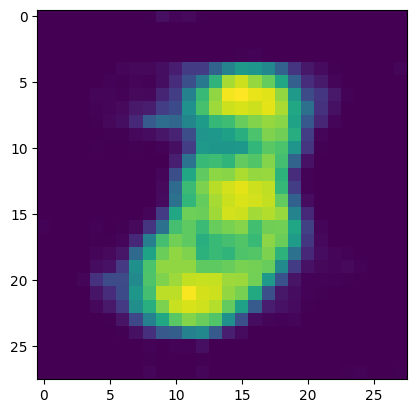

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(decoded_images[9][0].cpu().detach().numpy())

In [ ]:
#sampling:

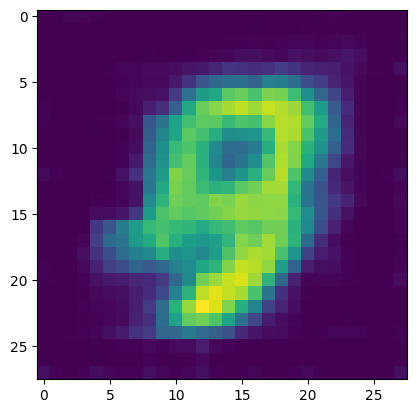

In [ ]:
sampled_batch = torch.normal(0, 1, size=(64,5))
generated_images = decoder(sampled_batch)
plt.imshow(generated_images[1][0].cpu().detach().numpy())